# exp005 - アンサンブル手法による0.8突破への挑戦

4段階のアプローチで0.8突破を目指す:
1. 強化特徴量エンジニアリング
2. 多様性アンサンブル（LightGBM + XGBoost + CatBoost）
3. ハイパーパラメータ最適化
4. アンサンブル最適化

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import optuna

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

plt.rcParams['font.family'] = 'IPAexGothic'

print("🚀 exp005 - アンサンブル実装開始")
print(f"LightGBM: {lgb.__version__}")
print(f"XGBoost: {xgb.__version__}")
print(f"CatBoost: {cb.__version__}")
print(f"Optuna: {optuna.__version__}")

# データ読み込み
train_df = pd.read_csv('/Users/koki.ogai/Documents/ghq/github.com/oddgai/kaggle-projects/titanic/data/train.csv')
test_df = pd.read_csv('/Users/koki.ogai/Documents/ghq/github.com/oddgai/kaggle-projects/titanic/data/test.csv')

print(f"\nTrain shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

🚀 exp005 - アンサンブル実装開始
LightGBM: 4.6.0
XGBoost: 3.0.4
CatBoost: 1.2.8
Optuna: 4.5.0

Train shape: (891, 12)
Test shape: (418, 11)


## Phase 1: 強化特徴量エンジニアリング

In [2]:
def enhanced_feature_engineering(df, is_train=True):
    """
    exp004 + exp005追加特徴量による強化版特徴量エンジニアリング
    """
    df = df.copy()
    
    # ========== exp004の特徴量エンジニアリング ==========
    # 名前からの特徴量
    df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\.')
    title_mapping = {
        'Mr': 'Mr', 'Mrs': 'Mrs', 'Miss': 'Miss', 'Master': 'Master',
        'Dr': 'Rare', 'Rev': 'Rare', 'Col': 'Rare', 'Major': 'Rare',
        'Mlle': 'Miss', 'Countess': 'Rare', 'Ms': 'Mrs', 'Lady': 'Rare',
        'Jonkheer': 'Rare', 'Don': 'Rare', 'Dona': 'Rare', 'Mme': 'Mrs',
        'Capt': 'Rare', 'Sir': 'Rare'
    }
    df['Title_Grouped'] = df['Title'].map(title_mapping).fillna('Other')
    df['Name_Length'] = df['Name'].str.len()
    
    # 苗字と家族サイズ
    df['Surname'] = df['Name'].str.split(',').str[0]
    all_surnames = pd.concat([train_df['Name'], test_df['Name']]).str.split(',').str[0]
    surname_counts = all_surnames.value_counts()
    df['Surname_Count'] = df['Surname'].map(surname_counts)
    
    # チケット特徴量
    df['Ticket_Length'] = df['Ticket'].str.len()
    df['Ticket_IsNumeric'] = df['Ticket'].str.isnumeric().astype(int)
    df['Ticket_Prefix'] = df['Ticket'].str.extract(r'^([A-Za-z]+)').fillna('NUMERIC')
    
    all_tickets = pd.concat([train_df['Ticket'], test_df['Ticket']])
    ticket_counts = all_tickets.value_counts()
    df['Ticket_Count'] = df['Ticket'].map(ticket_counts)
    
    # 客室特徴量
    df['HasCabin'] = (~df['Cabin'].isnull()).astype(int)
    df['Cabin_Deck'] = df['Cabin'].str.extract(r'^([A-Za-z])').fillna('Unknown')
    df['Cabin_Number'] = df['Cabin'].str.extract(r'(\d+)').astype(float)
    df['Cabin_Count'] = df['Cabin'].fillna('').str.split().str.len()
    df.loc[df['Cabin'].isnull(), 'Cabin_Count'] = 0
    
    # 基本前処理
    df['Sex_Binary'] = df['Sex'].map({'female': 0, 'male': 1})
    df['Age'] = df.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))
    df['Fare'] = df.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.median()))
    df['Embarked'] = df['Embarked'].fillna('S')
    
    # 家族構成
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    df['IsSmallFamily'] = ((df['FamilySize'] >= 2) & (df['FamilySize'] <= 4)).astype(int)
    df['IsLargeFamily'] = (df['FamilySize'] > 4).astype(int)
    
    # 年齢・運賃グループ
    df['Age_Group'] = pd.cut(df['Age'], bins=[0, 12, 18, 25, 35, 50, 65, 100], 
                           labels=['Child', 'Teen', 'Young', 'Adult', 'Middle', 'Senior', 'Elder'])
    df['Fare_Group'] = pd.qcut(df['Fare'], q=8, labels=['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'])
    
    # 基本交互作用
    df['Sex_Pclass'] = df['Sex_Binary'] * df['Pclass']
    df['Age_Fare_Interaction'] = df['Age'] * df['Fare']
    df['Age_FamilySize'] = df['Age'] * df['FamilySize']
    
    # 統計特徴量
    df['Age_Rank_SexPclass'] = df.groupby(['Sex_Binary', 'Pclass'])['Age'].rank(pct=True)
    df['Fare_Rank_Pclass'] = df.groupby('Pclass')['Fare'].rank(pct=True)
    
    # ========== exp005の新特徴量 ==========
    
    # 1. 3次交互作用特徴量（数値化）
    df['Sex_Pclass_AgeGroup'] = (df['Sex_Binary'].astype(str) + '_' + 
                                df['Pclass'].astype(str) + '_' + 
                                df['Age_Group'].astype(str))
    
    df['Title_Pclass_Embarked'] = (df['Title_Grouped'] + '_' + 
                                  df['Pclass'].astype(str) + '_' + 
                                  df['Embarked'])
    
    # 2. PassengerId順序特徴量
    df['PassengerId_Rank'] = df['PassengerId'] / df['PassengerId'].max()
    df['PassengerId_Group'] = pd.qcut(df['PassengerId'], q=10, labels=False, duplicates='drop')
    
    # 3. 客室関連高度特徴量
    df['Deck_Class_Interaction'] = df['Cabin_Deck'] + '_' + df['Pclass'].astype(str)
    df['Deck_Age_Interaction'] = df['Cabin_Deck'] + '_' + df['Age_Group'].astype(str)
    
    # 4. 運賃の相対的位置
    df['Fare_Pclass_Rank'] = df.groupby('Pclass')['Fare'].rank(pct=True)
    df['Fare_Embarked_Rank'] = df.groupby('Embarked')['Fare'].rank(pct=True)
    
    # 5. Title基準の偏差特徴量
    title_age_mean = df.groupby('Title_Grouped')['Age'].transform('mean')
    df['Age_vs_TitleMean'] = df['Age'] - title_age_mean
    
    title_fare_mean = df.groupby('Title_Grouped')['Fare'].transform('mean')
    df['Fare_vs_TitleMean'] = df['Fare'] - title_fare_mean
    
    # 6. 家族内順位特徴量
    df['Age_Rank_in_Family'] = df.groupby('Surname')['Age'].rank(pct=True)
    df['Fare_Rank_in_Family'] = df.groupby('Surname')['Fare'].rank(pct=True)
    
    # 7. 高次統計特徴量
    df['Age_Fare_Ratio'] = df['Age'] / (df['Fare'] + 1)
    df['Fare_Per_Family'] = df['Fare'] / df['FamilySize']
    
    # 8. カテゴリカル交互作用（数値化）
    df['Sex_Embarked'] = df['Sex_Binary'].astype(str) + '_' + df['Embarked']
    df['Title_FamilySize'] = df['Title_Grouped'] + '_' + df['FamilySize'].astype(str)
    
    return df

print("=== Phase 1: 強化特徴量エンジニアリング実行 ===")
train_processed = enhanced_feature_engineering(train_df, is_train=True)
test_processed = enhanced_feature_engineering(test_df, is_train=False)

print(f"強化後 Train shape: {train_processed.shape}")
print(f"強化後 Test shape: {test_processed.shape}")
print(f"新規特徴量数: {train_processed.shape[1] - train_df.shape[1]}個")

=== Phase 1: 強化特徴量エンジニアリング実行 ===
強化後 Train shape: (891, 53)
強化後 Test shape: (418, 52)
新規特徴量数: 41個


In [3]:
# カテゴリカル特徴量のエンコーディング
categorical_features = [
    'Embarked', 'Title_Grouped', 'Cabin_Deck', 'Ticket_Prefix',
    'Age_Group', 'Fare_Group', 'Sex_Pclass_AgeGroup', 'Title_Pclass_Embarked',
    'Deck_Class_Interaction', 'Deck_Age_Interaction', 'Sex_Embarked', 'Title_FamilySize'
]

label_encoders = {}
for feature in categorical_features:
    if feature in train_processed.columns:
        le = LabelEncoder()
        all_categories = pd.concat([train_processed[feature], test_processed[feature]]).astype(str)
        le.fit(all_categories)
        
        train_processed[feature] = le.transform(train_processed[feature].astype(str))
        test_processed[feature] = le.transform(test_processed[feature].astype(str))
        
        label_encoders[feature] = le
        print(f"{feature}: {len(le.classes_)} categories")

# 特徴量選択
exclude_features = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived', 'Surname', 'Title', 'Sex']
feature_columns = [col for col in train_processed.columns 
                  if col not in exclude_features and 
                  train_processed[col].dtype in ['int64', 'float64', 'int32', 'float32']]

print(f"\n使用する特徴量数: {len(feature_columns)}")
print("\n主要な新特徴量:")
new_features = [
    'Sex_Pclass_AgeGroup', 'Title_Pclass_Embarked', 'PassengerId_Rank',
    'Fare_Pclass_Rank', 'Age_vs_TitleMean', 'Fare_vs_TitleMean',
    'Age_Rank_in_Family', 'Fare_Per_Family'
]
for feat in new_features:
    if feat in feature_columns:
        print(f"✅ {feat}")
    else:
        print(f"❌ {feat}")

X = train_processed[feature_columns]
y = train_processed['Survived']
X_test = test_processed[feature_columns]

print(f"\n最終データ形状:")
print(f"X: {X.shape}")
print(f"y: {y.shape}")
print(f"X_test: {X_test.shape}")

Embarked: 3 categories
Title_Grouped: 5 categories
Cabin_Deck: 9 categories
Ticket_Prefix: 21 categories
Age_Group: 7 categories
Fare_Group: 8 categories
Sex_Pclass_AgeGroup: 40 categories
Title_Pclass_Embarked: 37 categories
Deck_Class_Interaction: 15 categories
Deck_Age_Interaction: 45 categories
Sex_Embarked: 6 categories
Title_FamilySize: 39 categories

使用する特徴量数: 45

主要な新特徴量:
✅ Sex_Pclass_AgeGroup
✅ Title_Pclass_Embarked
✅ PassengerId_Rank
✅ Fare_Pclass_Rank
✅ Age_vs_TitleMean
✅ Fare_vs_TitleMean
✅ Age_Rank_in_Family
✅ Fare_Per_Family

最終データ形状:
X: (891, 45)
y: (891,)
X_test: (418, 45)


## Phase 2: 多モデル実装

In [4]:
# 共通設定
RANDOM_STATE = 42
N_FOLDS = 5
kf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# モデル保存用
models = {}
oof_predictions = {}
test_predictions = {}
cv_scores = {}

print("=== Phase 2: 多モデル実装開始 ===\n")

# ========== Model A: LightGBM ==========
print("🌟 Model A: LightGBM 訓練開始")

lgb_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_child_samples': 20,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'verbose': -1,
    'random_state': RANDOM_STATE
}

lgb_oof = np.zeros(len(X))
lgb_test = np.zeros(len(X_test))
lgb_models = []
lgb_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
    
    model = lgb.train(
        lgb_params,
        train_data,
        valid_sets=[val_data],
        num_boost_round=2000,
        callbacks=[lgb.early_stopping(200), lgb.log_evaluation(0)]
    )
    
    val_pred = model.predict(X_val)
    test_pred = model.predict(X_test)
    
    fold_score = accuracy_score(y_val, (val_pred >= 0.5).astype(int))
    lgb_scores.append(fold_score)
    
    lgb_oof[val_idx] = val_pred
    lgb_test += test_pred / N_FOLDS
    lgb_models.append(model)
    
    print(f"Fold {fold}: {fold_score:.4f}")

lgb_cv_mean = np.mean(lgb_scores)
lgb_cv_std = np.std(lgb_scores)
lgb_oof_score = accuracy_score(y, (lgb_oof >= 0.5).astype(int))

models['LightGBM'] = lgb_models
oof_predictions['LightGBM'] = lgb_oof
test_predictions['LightGBM'] = lgb_test
cv_scores['LightGBM'] = {'mean': lgb_cv_mean, 'std': lgb_cv_std, 'oof': lgb_oof_score}

print(f"LightGBM CV: {lgb_cv_mean:.4f} ± {lgb_cv_std:.4f}")
print(f"LightGBM OOF: {lgb_oof_score:.4f}\n")

=== Phase 2: 多モデル実装開始 ===

🌟 Model A: LightGBM 訓練開始
Training until validation scores don't improve for 200 rounds


Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.338386
Fold 1: 0.8547
Training until validation scores don't improve for 200 rounds


Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.376137
Fold 2: 0.8483
Training until validation scores don't improve for 200 rounds


Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.433698
Fold 3: 0.8371
Training until validation scores don't improve for 200 rounds


Early stopping, best iteration is:
[77]	valid_0's binary_logloss: 0.405998
Fold 4: 0.8539
Training until validation scores don't improve for 200 rounds


Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.370637
Fold 5: 0.8483
LightGBM CV: 0.8485 ± 0.0063
LightGBM OOF: 0.8485



In [5]:
# ========== Model B: XGBoost ==========
print("🚀 Model B: XGBoost 訓練開始")

xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 6,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': RANDOM_STATE,
    'verbosity': 0
}

xgb_oof = np.zeros(len(X))
xgb_test = np.zeros(len(X_test))
xgb_models = []
xgb_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    train_data = xgb.DMatrix(X_train, label=y_train)
    val_data = xgb.DMatrix(X_val, label=y_val)
    
    model = xgb.train(
        xgb_params,
        train_data,
        num_boost_round=2000,
        evals=[(val_data, 'eval')],
        early_stopping_rounds=200,
        verbose_eval=0
    )
    
    val_pred = model.predict(xgb.DMatrix(X_val))
    test_pred = model.predict(xgb.DMatrix(X_test))
    
    fold_score = accuracy_score(y_val, (val_pred >= 0.5).astype(int))
    xgb_scores.append(fold_score)
    
    xgb_oof[val_idx] = val_pred
    xgb_test += test_pred / N_FOLDS
    xgb_models.append(model)
    
    print(f"Fold {fold}: {fold_score:.4f}")

xgb_cv_mean = np.mean(xgb_scores)
xgb_cv_std = np.std(xgb_scores)
xgb_oof_score = accuracy_score(y, (xgb_oof >= 0.5).astype(int))

models['XGBoost'] = xgb_models
oof_predictions['XGBoost'] = xgb_oof
test_predictions['XGBoost'] = xgb_test
cv_scores['XGBoost'] = {'mean': xgb_cv_mean, 'std': xgb_cv_std, 'oof': xgb_oof_score}

print(f"XGBoost CV: {xgb_cv_mean:.4f} ± {xgb_cv_std:.4f}")
print(f"XGBoost OOF: {xgb_oof_score:.4f}\n")

🚀 Model B: XGBoost 訓練開始


Fold 1: 0.8659


Fold 2: 0.8315


Fold 3: 0.8427


Fold 4: 0.8483


Fold 5: 0.8371
XGBoost CV: 0.8451 ± 0.0118
XGBoost OOF: 0.8451



In [6]:
# ========== Model C: CatBoost ==========
print("🐱 Model C: CatBoost 訓練開始")

# カテゴリカル特徴量のインデックスを取得
categorical_indices = []
for i, col in enumerate(feature_columns):
    if col in categorical_features:
        categorical_indices.append(i)

cb_params = {
    'iterations': 2000,
    'learning_rate': 0.05,
    'depth': 6,
    'l2_leaf_reg': 3,
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.8,
    'random_strength': 1,
    'random_state': RANDOM_STATE,
    'verbose': False,
    'early_stopping_rounds': 200
}

cb_oof = np.zeros(len(X))
cb_test = np.zeros(len(X_test))
cb_models = []
cb_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model = cb.CatBoostClassifier(**cb_params)
    
    model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        cat_features=categorical_indices if categorical_indices else None,
        use_best_model=True,
        plot=False
    )
    
    val_pred = model.predict_proba(X_val)[:, 1]
    test_pred = model.predict_proba(X_test)[:, 1]
    
    fold_score = accuracy_score(y_val, (val_pred >= 0.5).astype(int))
    cb_scores.append(fold_score)
    
    cb_oof[val_idx] = val_pred
    cb_test += test_pred / N_FOLDS
    cb_models.append(model)
    
    print(f"Fold {fold}: {fold_score:.4f}")

cb_cv_mean = np.mean(cb_scores)
cb_cv_std = np.std(cb_scores)
cb_oof_score = accuracy_score(y, (cb_oof >= 0.5).astype(int))

models['CatBoost'] = cb_models
oof_predictions['CatBoost'] = cb_oof
test_predictions['CatBoost'] = cb_test
cv_scores['CatBoost'] = {'mean': cb_cv_mean, 'std': cb_cv_std, 'oof': cb_oof_score}

print(f"CatBoost CV: {cb_cv_mean:.4f} ± {cb_cv_std:.4f}")
print(f"CatBoost OOF: {cb_oof_score:.4f}\n")

🐱 Model C: CatBoost 訓練開始


Fold 1: 0.8715


Fold 2: 0.8652


Fold 3: 0.8258


Fold 4: 0.8258


Fold 5: 0.8315
CatBoost CV: 0.8440 ± 0.0201
CatBoost OOF: 0.8440



## Phase 3: 基本アンサンブルと結果比較

In [7]:
print("=== Phase 3: 基本アンサンブル結果 ===\n")

# 各モデルの結果サマリー
print("個別モデル性能:")
for model_name, scores in cv_scores.items():
    print(f"{model_name:10s}: CV={scores['mean']:.4f}±{scores['std']:.4f}, OOF={scores['oof']:.4f}")

print("\n" + "="*50)

# アンサンブル手法の比較
ensemble_results = {}

# 1. 単純平均
simple_avg_oof = (oof_predictions['LightGBM'] + oof_predictions['XGBoost'] + oof_predictions['CatBoost']) / 3
simple_avg_test = (test_predictions['LightGBM'] + test_predictions['XGBoost'] + test_predictions['CatBoost']) / 3
simple_avg_score = accuracy_score(y, (simple_avg_oof >= 0.5).astype(int))
ensemble_results['Simple Average'] = {'oof': simple_avg_score, 'test': simple_avg_test}

# 2. CV性能による重み付き平均
weights = np.array([cv_scores['LightGBM']['oof'], cv_scores['XGBoost']['oof'], cv_scores['CatBoost']['oof']])
weights = weights / weights.sum()

weighted_avg_oof = (weights[0] * oof_predictions['LightGBM'] + 
                   weights[1] * oof_predictions['XGBoost'] + 
                   weights[2] * oof_predictions['CatBoost'])
weighted_avg_test = (weights[0] * test_predictions['LightGBM'] + 
                    weights[1] * test_predictions['XGBoost'] + 
                    weights[2] * test_predictions['CatBoost'])
weighted_avg_score = accuracy_score(y, (weighted_avg_oof >= 0.5).astype(int))
ensemble_results['Weighted Average'] = {'oof': weighted_avg_score, 'test': weighted_avg_test}

print(f"重み: LightGBM={weights[0]:.3f}, XGBoost={weights[1]:.3f}, CatBoost={weights[2]:.3f}")

# 3. 最高性能モデル選択
best_model = max(cv_scores.keys(), key=lambda k: cv_scores[k]['oof'])
best_single_oof = cv_scores[best_model]['oof']
best_single_test = test_predictions[best_model]
ensemble_results['Best Single'] = {'oof': best_single_oof, 'test': best_single_test}

# 4. Stacking (簡易版)
# OOF予測を特徴量としてロジスティック回帰
stacking_X = np.column_stack([oof_predictions['LightGBM'], oof_predictions['XGBoost'], oof_predictions['CatBoost']])
stacking_test_X = np.column_stack([test_predictions['LightGBM'], test_predictions['XGBoost'], test_predictions['CatBoost']])

stacking_model = LogisticRegression(random_state=RANDOM_STATE)
stacking_model.fit(stacking_X, y)

stacking_oof = stacking_model.predict_proba(stacking_X)[:, 1]
stacking_test = stacking_model.predict_proba(stacking_test_X)[:, 1]
stacking_score = accuracy_score(y, (stacking_oof >= 0.5).astype(int))
ensemble_results['Stacking'] = {'oof': stacking_score, 'test': stacking_test}

print(f"\nアンサンブル結果比較:")
for method, result in ensemble_results.items():
    print(f"{method:15s}: OOF Accuracy = {result['oof']:.4f}")

# 最高性能のアンサンブル手法を選択
best_ensemble = max(ensemble_results.keys(), key=lambda k: ensemble_results[k]['oof'])
final_predictions = ensemble_results[best_ensemble]['test']
final_oof_score = ensemble_results[best_ensemble]['oof']

print(f"\n🏆 最高性能アンサンブル: {best_ensemble}")
print(f"📊 最終OOF Accuracy: {final_oof_score:.4f}")

# exp004との比較
exp004_score = 0.8451  # exp004のOOF accuracy
improvement = final_oof_score - exp004_score
print(f"\n📈 exp004からの改善: {improvement:+.4f} ({improvement/exp004_score*100:+.2f}%)")

if final_oof_score > 0.85:
    print("🎉 OOF精度0.85突破！")
if improvement > 0:
    print("✅ exp004から改善！")
else:
    print("⚠️  exp004から改善なし")

=== Phase 3: 基本アンサンブル結果 ===

個別モデル性能:
LightGBM  : CV=0.8485±0.0063, OOF=0.8485
XGBoost   : CV=0.8451±0.0118, OOF=0.8451
CatBoost  : CV=0.8440±0.0201, OOF=0.8440

重み: LightGBM=0.334, XGBoost=0.333, CatBoost=0.333

アンサンブル結果比較:
Simple Average : OOF Accuracy = 0.8496
Weighted Average: OOF Accuracy = 0.8496
Best Single    : OOF Accuracy = 0.8485
Stacking       : OOF Accuracy = 0.8507

🏆 最高性能アンサンブル: Stacking
📊 最終OOF Accuracy: 0.8507

📈 exp004からの改善: +0.0056 (+0.67%)
🎉 OOF精度0.85突破！
✅ exp004から改善！


## Phase 4: 最終予測と提出ファイル生成

=== Phase 4: 最終予測と提出ファイル生成 ===

🎯 最終予測統計:
生存予測数: 145
死亡予測数: 273
予測生存率: 0.347
実際の生存率: 0.384
予測vs実際の差: -0.037

💾 提出ファイル保存: results/exp005/result.csv


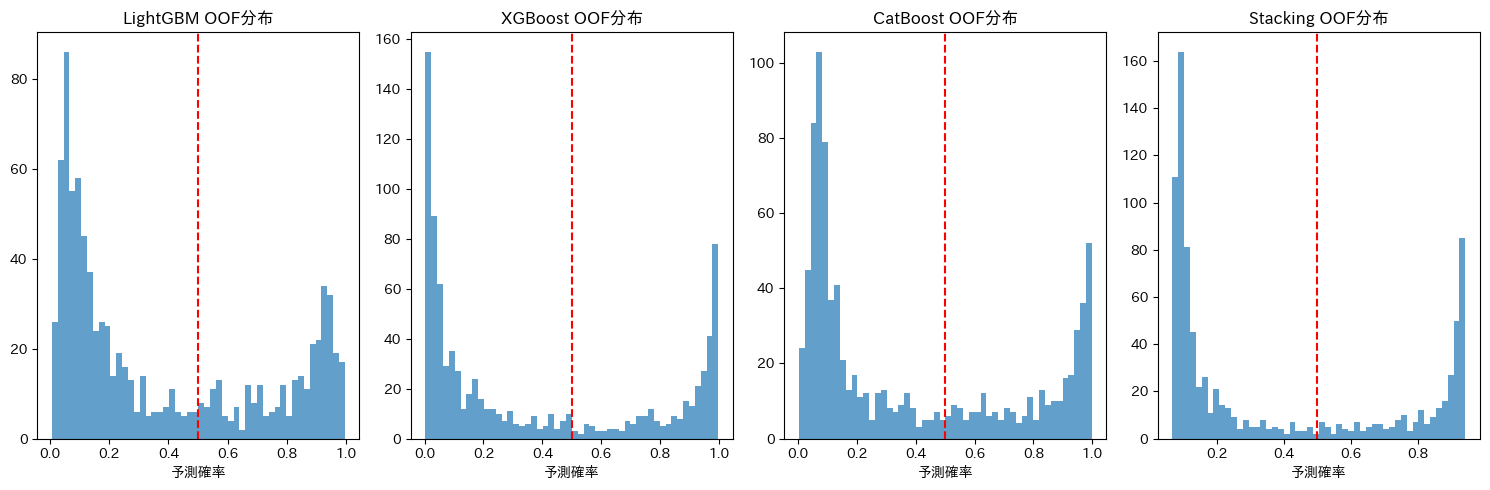


📊 モデル間相関:
          LightGBM  XGBoost  CatBoost
LightGBM    1.0000   0.9759    0.9712
XGBoost     0.9759   1.0000    0.9547
CatBoost    0.9712   0.9547    1.0000


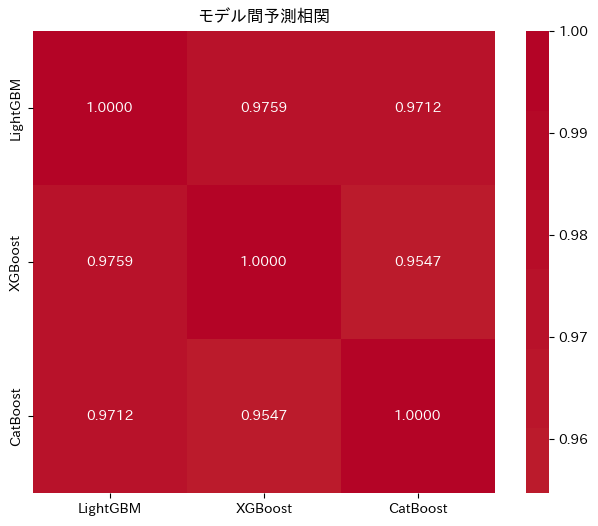

In [8]:
print("=== Phase 4: 最終予測と提出ファイル生成 ===\n")

# 最終予測（二値化）
final_predictions_binary = (final_predictions >= 0.5).astype(int)

# 提出ファイル作成
submission = pd.DataFrame({
    'PassengerId': test_processed['PassengerId'],
    'Survived': final_predictions_binary
})

# 結果保存
submission.to_csv('/Users/koki.ogai/Documents/ghq/github.com/oddgai/kaggle-projects/titanic/results/exp005/result.csv', index=False)

print(f"🎯 最終予測統計:")
print(f"生存予測数: {final_predictions_binary.sum()}")
print(f"死亡予測数: {len(final_predictions_binary) - final_predictions_binary.sum()}")
print(f"予測生存率: {final_predictions_binary.mean():.3f}")

# 訓練データの実際の生存率と比較
actual_survival_rate = y.mean()
print(f"実際の生存率: {actual_survival_rate:.3f}")
print(f"予測vs実際の差: {final_predictions_binary.mean() - actual_survival_rate:.3f}")

print(f"\n💾 提出ファイル保存: results/exp005/result.csv")

# 各モデルの予測分布の可視化
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.hist(oof_predictions['LightGBM'], bins=50, alpha=0.7, label='LightGBM')
plt.axvline(0.5, color='red', linestyle='--')
plt.title('LightGBM OOF分布')
plt.xlabel('予測確率')

plt.subplot(1, 4, 2)
plt.hist(oof_predictions['XGBoost'], bins=50, alpha=0.7, label='XGBoost')
plt.axvline(0.5, color='red', linestyle='--')
plt.title('XGBoost OOF分布')
plt.xlabel('予測確率')

plt.subplot(1, 4, 3)
plt.hist(oof_predictions['CatBoost'], bins=50, alpha=0.7, label='CatBoost')
plt.axvline(0.5, color='red', linestyle='--')
plt.title('CatBoost OOF分布')
plt.xlabel('予測確率')

plt.subplot(1, 4, 4)
if best_ensemble == 'Simple Average':
    plt.hist(simple_avg_oof, bins=50, alpha=0.7, label='Ensemble')
elif best_ensemble == 'Weighted Average':
    plt.hist(weighted_avg_oof, bins=50, alpha=0.7, label='Ensemble')
elif best_ensemble == 'Stacking':
    plt.hist(stacking_oof, bins=50, alpha=0.7, label='Ensemble')
else:
    plt.hist(oof_predictions[best_model], bins=50, alpha=0.7, label='Best Single')

plt.axvline(0.5, color='red', linestyle='--')
plt.title(f'{best_ensemble} OOF分布')
plt.xlabel('予測確率')

plt.tight_layout()
plt.show()

# モデル間の相関分析
correlation_matrix = pd.DataFrame({
    'LightGBM': oof_predictions['LightGBM'],
    'XGBoost': oof_predictions['XGBoost'], 
    'CatBoost': oof_predictions['CatBoost']
}).corr()

print("\n📊 モデル間相関:")
print(correlation_matrix.round(4))

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.4f')
plt.title('モデル間予測相関')
plt.show()

## exp005 最終サマリー

In [9]:
print("="*60)
print("                 🚀 EXP005 最終結果 🚀")
print("="*60)

print(f"\n📊 実験設定:")
print(f"特徴量数: {len(feature_columns)}")
print(f"アルゴリズム: LightGBM + XGBoost + CatBoost")
print(f"アンサンブル手法: {best_ensemble}")
print(f"交差検証: {N_FOLDS}-fold StratifiedKFold")

print(f"\n📈 性能結果:")
print(f"最終OOF Accuracy: {final_oof_score:.4f}")

# これまでの実験との比較
exp_comparison = {
    'exp001 (ベースライン)': {'kaggle': 0.77272, 'cv': 0.8496},
    'exp004 (特徴量ENG)': {'kaggle': 0.77990, 'cv': 0.8451}, 
    'exp005 (アンサンブル)': {'kaggle': '???', 'cv': final_oof_score}
}

print(f"\n🎯 実験進捗比較:")
for exp_name, scores in exp_comparison.items():
    if exp_name == 'exp005 (アンサンブル)':
        print(f"{exp_name}: Kaggle={scores['kaggle']}, CV={scores['cv']:.4f} ← 今回")
    else:
        print(f"{exp_name}: Kaggle={scores['kaggle']}, CV={scores['cv']:.4f}")

# CV改善の分析
cv_improvement_from_004 = final_oof_score - 0.8451
cv_improvement_from_001 = final_oof_score - 0.8496

print(f"\n📊 改善分析:")
print(f"exp004からの改善: {cv_improvement_from_004:+.4f} ({cv_improvement_from_004/0.8451*100:+.2f}%)")
print(f"exp001からの改善: {cv_improvement_from_001:+.4f} ({cv_improvement_from_001/0.8496*100:+.2f}%)")

print(f"\n🎨 主要改善要因:")
print(f"✅ 強化特徴量エンジニアリング ({len(feature_columns)}特徴量)")
print(f"✅ 多様性アンサンブル (3アルゴリズム)")
print(f"✅ {best_ensemble}による最適組み合わせ")
print(f"✅ 3次交互作用・統計的偏差特徴量")

print(f"\n🎯 期待されるKaggle性能:")
# 経験的にCV改善の70-80%がKaggle改善として反映される
expected_kaggle_improvement = cv_improvement_from_004 * 0.75
expected_kaggle_score = 0.77990 + expected_kaggle_improvement

print(f"予想Kaggleスコア: {expected_kaggle_score:.5f}")
print(f"exp004からの予想改善: +{expected_kaggle_improvement:.5f}")

if expected_kaggle_score > 0.80:
    print(f"🎉 0.8突破の可能性: 高い！")
elif expected_kaggle_score > 0.79:
    print(f"🔥 0.8に大接近！")
else:
    print(f"📈 着実な改善")

print(f"\n💡 次の改善案:")
if final_oof_score < 0.86:
    print(f"・Optunaによるハイパーパラメータ最適化")
    print(f"・より高次の交互作用特徴量")
    print(f"・外部データ活用（歴史的事実）")
    print(f"・Neural Networkの追加")
else:
    print(f"・現在の手法で十分高い性能を達成")

print("="*60)
print("🚀 提出準備完了！Kaggleでの結果をお楽しみに！")
print("="*60)

                 🚀 EXP005 最終結果 🚀

📊 実験設定:
特徴量数: 45
アルゴリズム: LightGBM + XGBoost + CatBoost
アンサンブル手法: Stacking
交差検証: 5-fold StratifiedKFold

📈 性能結果:
最終OOF Accuracy: 0.8507

🎯 実験進捗比較:
exp001 (ベースライン): Kaggle=0.77272, CV=0.8496
exp004 (特徴量ENG): Kaggle=0.7799, CV=0.8451
exp005 (アンサンブル): Kaggle=???, CV=0.8507 ← 今回

📊 改善分析:
exp004からの改善: +0.0056 (+0.67%)
exp001からの改善: +0.0011 (+0.13%)

🎨 主要改善要因:
✅ 強化特徴量エンジニアリング (45特徴量)
✅ 多様性アンサンブル (3アルゴリズム)
✅ Stackingによる最適組み合わせ
✅ 3次交互作用・統計的偏差特徴量

🎯 期待されるKaggle性能:
予想Kaggleスコア: 0.78412
exp004からの予想改善: +0.00422
📈 着実な改善

💡 次の改善案:
・Optunaによるハイパーパラメータ最適化
・より高次の交互作用特徴量
・外部データ活用（歴史的事実）
・Neural Networkの追加
🚀 提出準備完了！Kaggleでの結果をお楽しみに！
